# Uncertainty-aware Deep Language Learning with BERT-SNGP

**Learning Objectives**:

* Learn how to build a [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) model for text classification
* Learn how augment the BERT classifier with a Spectral Normalized Gaussian Process (SNGP) to improve the uncertainty quality
* Learn how to Load the [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset and train BERT-SNGP on this dataset
* Evaluate the BERT-SNGP model's performance in uncertainty calibration and out-of-domain detection.

In this notebook, you will apply SNGP to a natural language understanding (NLU) task by building it on top of a deep BERT encoder to improve deep NLU model's ability in detecting out-of-scope queries. 
For the purpose of notebook,  we will use [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. However, the SNGP model has been applied to large-scale datasets such as [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), and to the image datasets such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) and [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012). 
For benchmark results of SNGP and other uncertainty methods, as well as high-quality implementation with end-to-end training / evaluation scripts, you can check out the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

## Setup

In [1]:
pip freeze | grep tf-models-official || pip install tf-models-official==2.8.0

tf-models-official==2.8.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import official.nlp.modeling.layers as layers
import official.nlp.optimization as optimization
import sklearn.calibration
import sklearn.metrics
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

This tutorial needs the GPU to run efficiently. Check if the GPU is available. 

In [3]:
tf.__version__

'2.8.3'

In [4]:
gpus = tf.config.list_physical_devices("GPU")
gpus

2022-09-17 00:30:01.778432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 00:30:01.910365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 00:30:01.912205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
assert gpus, """
  No GPU(s) found! This tutorial will take many hours to run without a GPU.

  You may hit this error if the installed tensorflow package is not
  compatible with the CUDA and CUDNN versions."""

## Implement a classification BERT model 

First, we will implement a standard BERT classifier using the Keras model API (see our [classify text with BERT](notebooks/text_models/solutions/classify_text_with_bert.ipynb) tutorial for more details on the BERT model). We will use the [BERT-base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) encoder, and the built-in [`ClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py) as the classifier.

In [6]:
PREPROCESS_HANDLE = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
MODEL_HANDLE = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"


class BertClassifier(tf.keras.Model):
    def __init__(
        self,
        num_classes=150,
        inner_dim=768,
        dropout_rate=0.1,
        **classifier_kwargs,
    ):

        super().__init__()
        self.classifier_kwargs = classifier_kwargs

        # Initiate the BERT encoder components.
        self.bert_preprocessor = hub.KerasLayer(
            PREPROCESS_HANDLE, name="preprocessing"
        )
        self.bert_hidden_layer = hub.KerasLayer(
            MODEL_HANDLE, trainable=True, name="bert_encoder"
        )

        # Defines the encoder and classification layers.
        self.bert_encoder = self.make_bert_encoder()
        self.classifier = self.make_classification_head(
            num_classes, inner_dim, dropout_rate
        )

    def make_bert_encoder(self):
        text_inputs = tf.keras.layers.Input(
            shape=(), dtype=tf.string, name="text"
        )
        encoder_inputs = self.bert_preprocessor(text_inputs)
        encoder_outputs = self.bert_hidden_layer(encoder_inputs)
        return tf.keras.Model(text_inputs, encoder_outputs)

    def make_classification_head(self, num_classes, inner_dim, dropout_rate):
        return layers.ClassificationHead(
            num_classes=num_classes,
            inner_dim=inner_dim,
            dropout_rate=dropout_rate,
            **self.classifier_kwargs,
        )

    def call(self, inputs, **kwargs):
        encoder_outputs = self.bert_encoder(inputs)
        classifier_inputs = encoder_outputs["sequence_output"]
        return self.classifier(classifier_inputs, **kwargs)

### Build SNGP model

To implement a BERT-SNGP model, you only need to replace the `ClassificationHead` with the built-in [`GaussianProcessClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py). Spectral normalization is already pre-packaged into this classification head. Like in the [SNGP tutorial](https://www.tensorflow.org/tutorials/uncertainty/sngp), add a covariance reset callback to the model, so the model automatically reset the covariance estimator at the begining of a new epoch to avoid counting the same data twice.

In [7]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the begining of the epoch."""
        if epoch > 0:
            self.model.classifier.reset_covariance_matrix()

In [8]:
class SNGPBertClassifier(BertClassifier):
    def make_classification_head(self, num_classes, inner_dim, dropout_rate):
        return layers.GaussianProcessClassificationHead(
            num_classes=num_classes,
            inner_dim=inner_dim,
            dropout_rate=dropout_rate,
            gp_cov_momentum=-1,
            temperature=30.0,
            **self.classifier_kwargs,
        )

    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())

        return super().fit(*args, **kwargs)

**Note:** The `GaussianProcessClassificationHead` takes a new argument `temperature`. It corresponds to the $\lambda$ parameter in the __mean-field approximation__ introduced in the [SNGP lab](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/uncertainty_aware_models/solutions/uncertainty_awareness_in_deep_learning.ipynb). In practice, this value is usually treated as a hyperparameter, and is finetuned to optimize the model's calibration performance.

### Load CLINC OOS dataset

Now load the [CLINC OOS](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. This dataset contains 15000 user's spoken queries collected over 150 intent classes, it also contains 1000 out-of-domain (OOD) sentences that are not covered by any of the known classes.

In [9]:
(clinc_train, clinc_test, clinc_test_oos), ds_info = tfds.load(
    "clinc_oos",
    split=["train", "test", "test_oos"],
    with_info=True,
    batch_size=-1,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/6 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/15000 [00:00<?, ? examples/s]

Shuffling clinc_oos-train.tfrecord...:   0%|          | 0/15000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/4500 [00:00<?, ? examples/s]

Shuffling clinc_oos-test.tfrecord...:   0%|          | 0/4500 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/3000 [00:00<?, ? examples/s]

Shuffling clinc_oos-validation.tfrecord...:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating train_oos examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling clinc_oos-train_oos.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test_oos examples...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Shuffling clinc_oos-test_oos.tfrecord...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation_oos examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling clinc_oos-validation_oos.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /home/jupyter/tensorflow_datasets/clinc_oos/0.1.0. Subsequent calls will reuse this data.


2022-09-17 00:30:14.297940: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 00:30:14.327726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 00:30:14.331452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 00:30:14.334154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Make the train and test data.

In [10]:
train_examples = clinc_train["text"]
train_labels = clinc_train["intent"]

# Makes the in-domain (IND) evaluation data.
ind_eval_data = (clinc_test["text"], clinc_test["intent"])

In [18]:
train_examples[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'please inform me when my flight scheduled to board'>

In [19]:
train_labels[0]

<tf.Tensor: shape=(), dtype=int32, numpy=85>

Create a OOD evaluation dataset. For this, combine the in-domain test data `clinc_test` and the out-of-domain data `clinc_test_oos`. We will also assign label 0 to the in-domain examples, and label 1 to the out-of-domain examples. 

In [11]:
test_data_size = ds_info.splits["test"].num_examples
oos_data_size = ds_info.splits["test_oos"].num_examples

# Combines the in-domain and out-of-domain test examples.
oos_texts = tf.concat([clinc_test["text"], clinc_test_oos["text"]], axis=0)
oos_labels = tf.constant([0] * test_data_size + [1] * oos_data_size)

# Converts into a TF dataset.
ood_eval_dataset = tf.data.Dataset.from_tensor_slices(
    {"text": oos_texts, "label": oos_labels}
)

### Train and evaluate

First set up the basic training configurations.

In [12]:
TRAIN_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 256

In [13]:
def bert_optimizer(
    learning_rate,
    batch_size=TRAIN_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    warmup_rate=0.1,
):
    """Creates an AdamWeightDecay optimizer with learning rate schedule."""
    train_data_size = ds_info.splits["train"].num_examples

    steps_per_epoch = int(train_data_size / batch_size)
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(warmup_rate * num_train_steps)

    # Creates learning schedule.
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=num_train_steps,
        end_learning_rate=0.0,
    )

    return optimization.AdamWeightDecay(
        learning_rate=lr_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"],
    )

In [14]:
optimizer = bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [15]:
fit_configs = dict(
    batch_size=TRAIN_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    validation_batch_size=EVAL_BATCH_SIZE,
    validation_data=ind_eval_data,
)

In [16]:
sngp_model = SNGPBertClassifier()
sngp_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model.fit(train_examples, train_labels, **fit_configs)

Epoch 1/3


2022-09-17 00:31:14.392272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


469/469 [==============================] - ETA: 0s - loss: 1.2155 - sparse_categorical_accuracy: 0.7662

2022-09-17 00:38:17.520332: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5640ced389e0


469/469 [==============================] - 527s 1s/step - loss: 1.2155 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.9362
Epoch 2/3
469/469 [==============================] - 502s 1s/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.2423 - val_sparse_categorical_accuracy: 0.9571
Epoch 3/3
469/469 [==============================] - 501s 1s/step - loss: 0.0242 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.1835 - val_sparse_categorical_accuracy: 0.9636


### Evaluate OOD performance

Evaluate how well the model can detect the unfamiliar out-of-domain queries. For rigorous evaluation, use the OOD evaluation dataset `ood_eval_dataset` built earlier.

In [55]:
def oos_predict(model, ood_eval_dataset, **model_kwargs):
    oos_labels = []
    oos_probs = []

    ood_eval_dataset = ood_eval_dataset.batch(EVAL_BATCH_SIZE)
    for oos_batch in ood_eval_dataset:
        oos_text_batch = oos_batch["text"]
        oos_label_batch = oos_batch["label"]

        pred_logits = model(oos_text_batch, **model_kwargs)
        pred_probs_all = tf.nn.softmax(pred_logits, axis=-1)
        pred_probs = tf.reduce_max(pred_probs_all, axis=-1)

        oos_labels.append(oos_label_batch)
        oos_probs.append(pred_probs)

    oos_probs = tf.concat(oos_probs, axis=0)
    oos_labels = tf.concat(oos_labels, axis=0)

    return oos_probs, oos_labels

Computes the OOD probabilities as $1 - p(x)$, where $p(x)=\textrm{softmax}(\textrm{logit}(x))$ is the predictive probability.

In [56]:
sngp_probs, ood_labels = oos_predict(sngp_model, ood_eval_dataset)

In [57]:
ood_probs = 1 - sngp_probs

Now evaluate how well the model's uncertainty score `ood_probs` predicts the out-of-domain label. First compute the Area under precision-recall curve (AUPRC) for OOD probability v.s. OOD detection accuracy.

In [58]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(
    ood_labels, ood_probs
)

In [59]:
auprc = sklearn.metrics.auc(recall, precision)
print(f"SNGP AUPRC: {auprc:.4f}")

SNGP AUPRC: 0.8947


This matches the SNGP performance reported at the CLINC OOS benchmark under the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines).

Next, examine the model's quality in [uncertainty calibration](https://scikit-learn.org/stable/modules/calibration.html), i.e., whether the model's predictive probability corresponds to its predictive accuracy. A well-calibrated model is considered trust-worthy, since, for example, its predictive probability $p(x)=0.8$ means that the model is correct 80% of the time.

In [60]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, ood_probs, n_bins=10, strategy="quantile"
)

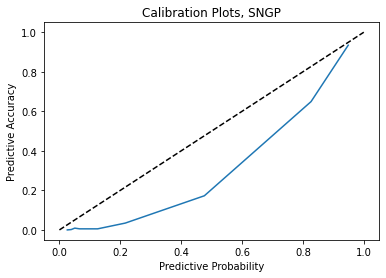

In [61]:
plt.plot(prob_pred, prob_true)

plt.plot([0.0, 1.0], [0.0, 1.0], c="k", linestyle="--")
plt.xlabel("Predictive Probability")
plt.ylabel("Predictive Accuracy")
plt.title("Calibration Plots, SNGP")

plt.show()

## Resources and further reading

* See the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp) for an detailed walkthrough of implementing SNGP from scratch. 
* See [Uncertainty Baselines](https://github.com/google/uncertainty-baselines)  for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).


Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.